# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## First, I'll compute the camera calibration using chessboard images

In [2]:
def Calibrate_Camera():
    """
    Camera Calibration using chessboard images
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y co-ordinates

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx, dist

## Camera Calibration Illustration

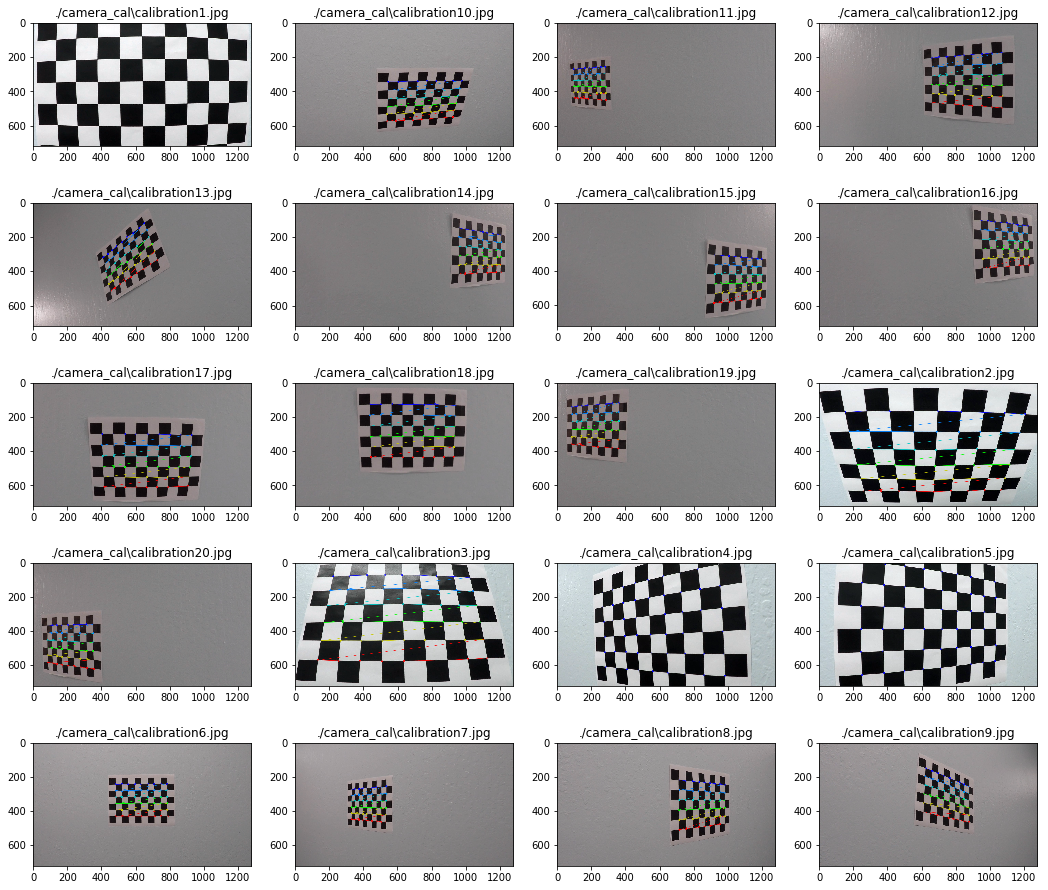

In [3]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

plt.figure(figsize=(18,16))
# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
#     if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)    
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    plt.subplot(5, 4, i+1)
    plt.imshow(img)
    plt.title(fname)
plt.show()

From above we can see that there are 3 images calibration1.jpg, calibration4.jpg and calibration5.jpg which do not have any 
corner lines connected to them because the number of specified corners are not being found in these images. So they are not 
used for camera calibration.


## Apply a distortion correction to raw images.

In [4]:
# Do camera calibration given object points and image points
mtx, dist = Calibrate_Camera()

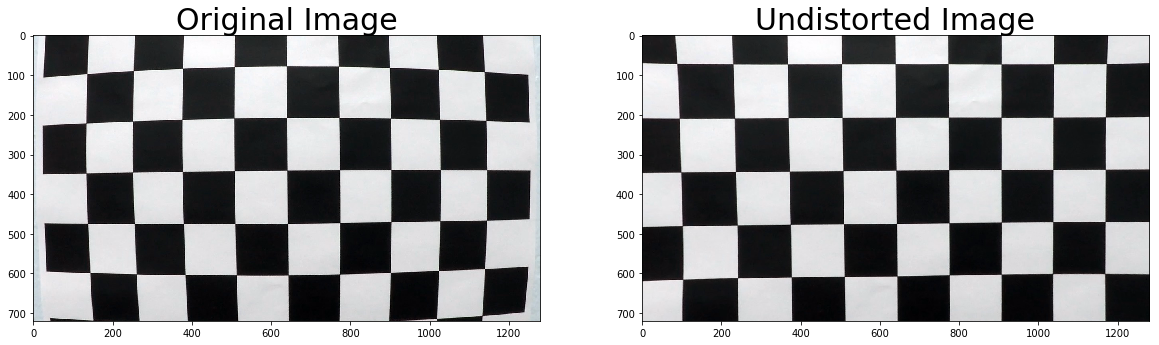

In [5]:
# Test undistortion on an image
# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30) 

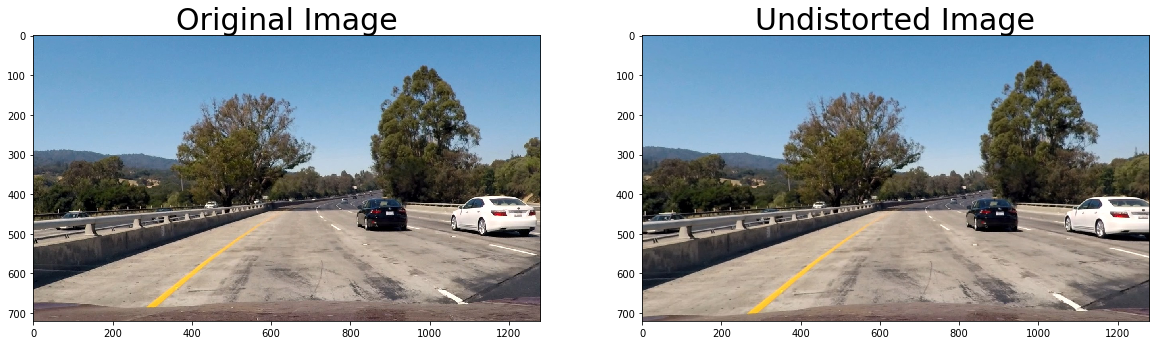

In [35]:
# Test undistortion on an image
# Read in an image
img = mpimg.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30) 

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir_grad =  np.arctan2(abs_sobely, abs_sobelx)
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(dir_grad)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return binary_output

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def Gradient_Threshold(undistort_img):   
    # convert to gray scale
    gray = cv2.cvtColor(undistort_img, cv2.COLOR_RGB2GRAY)
      
    # apply gradient threshold on the horizontal gradient
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(10, 200))
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, sobel_kernel=3, thresh=(0.7, 1.4))    
    
    # combine the gradient and direction thresholds.
    combined = ((gradx == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R_channel = undistort_img[:,:,0]
    G_channel = undistort_img[:,:,1] 
    r_g_condition = (R_channel > color_threshold) & (G_channel > color_threshold)
    
    
    # HLS Channel Thresholds
    hls = cv2.cvtColor(undistort_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (90, 255)
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])

    # combine all the thresholds, pixel should be either yellowish or white in color
    color_combined = np.zeros_like(R_channel)
    color_combined[(r_g_condition & l_condition) & (s_condition | combined)] = 1
    
    return color_combined

## Color Transform, Gradient -> Thresholded Binary Image Illustration

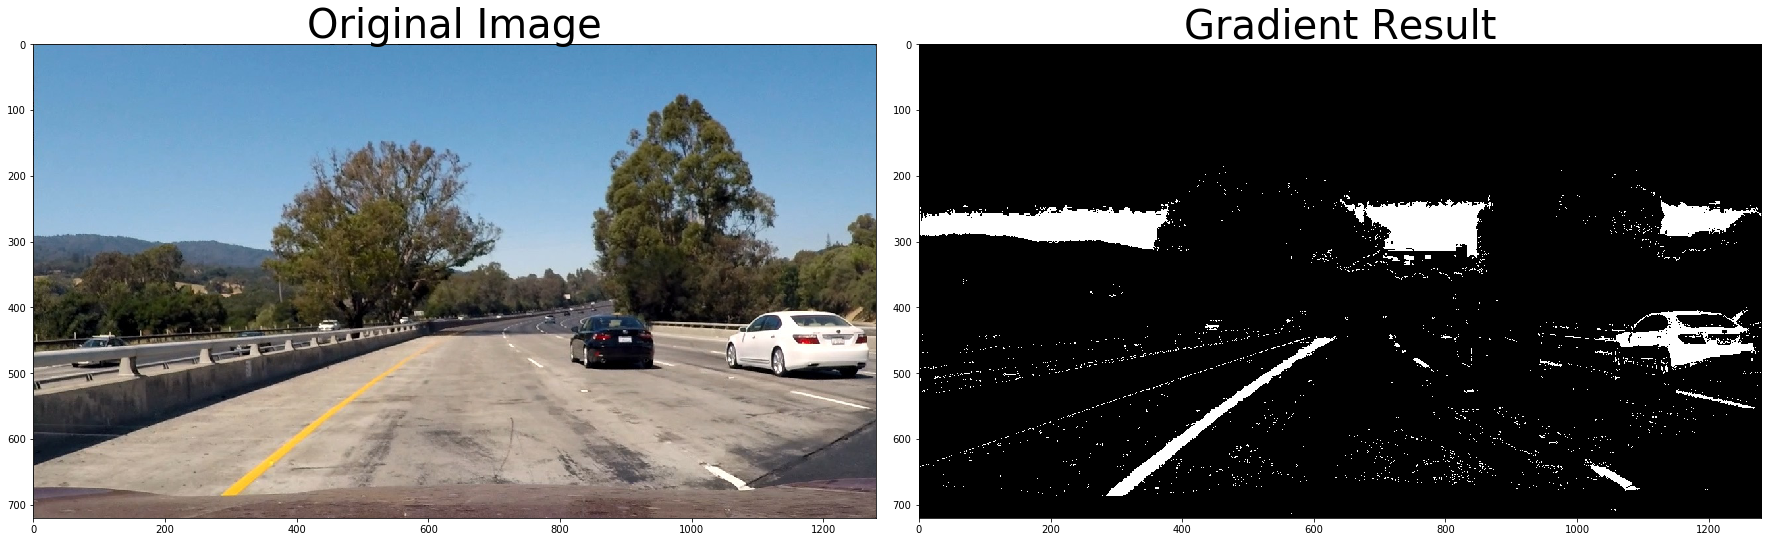

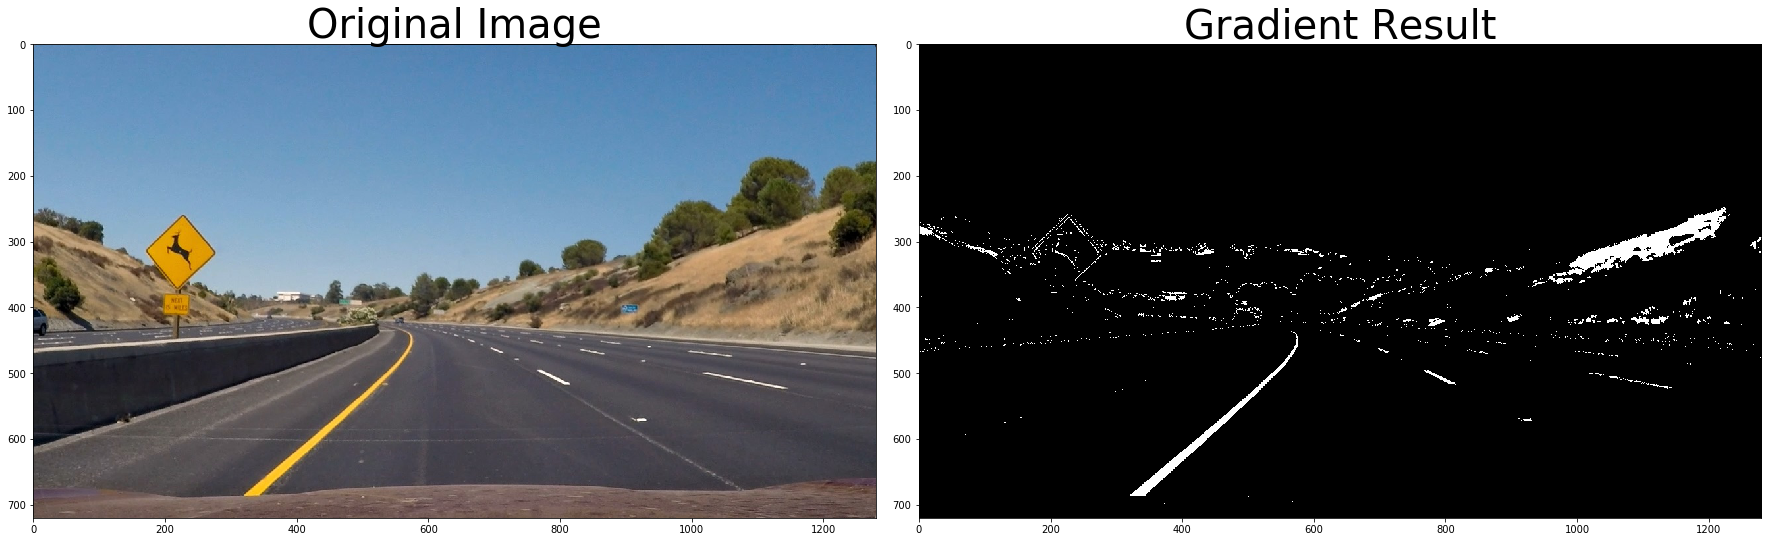

In [7]:
image = mpimg.imread('test_images/test1.jpg')
# undistort = cv2.undistort(img, mtx, dist, None, mtx)
result = Gradient_Threshold(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result, cmap='gray')
ax2.set_title('Gradient Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

image = mpimg.imread('test_images/test2.jpg')
# undistort = cv2.undistort(img, mtx, dist, None, mtx)
result = Gradient_Threshold(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result, cmap='gray')
ax2.set_title('Gradient Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def region_of_interest(binary_img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(binary_img)   
    
    ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(binary_img, mask)
    return masked_image

def apply_roi(binary_img):
    """
    This function applies region of interest to a binary image
    
    vertices are fixed inside the function
    """
    # Defining vertices for marked area
    height, width = binary_img.shape
    left_bottom = (0, height - 1)
    right_bottom = (width-1, height - 1)
    apex1 = (width/2, int(0.5*height))
    vertices = np.array([[left_bottom, apex1, right_bottom]], dtype=np.int32)
    # Masked area
    roi_binary = region_of_interest(binary_img, vertices)
    return roi_binary

## Region of Interest (Masking) Visualization

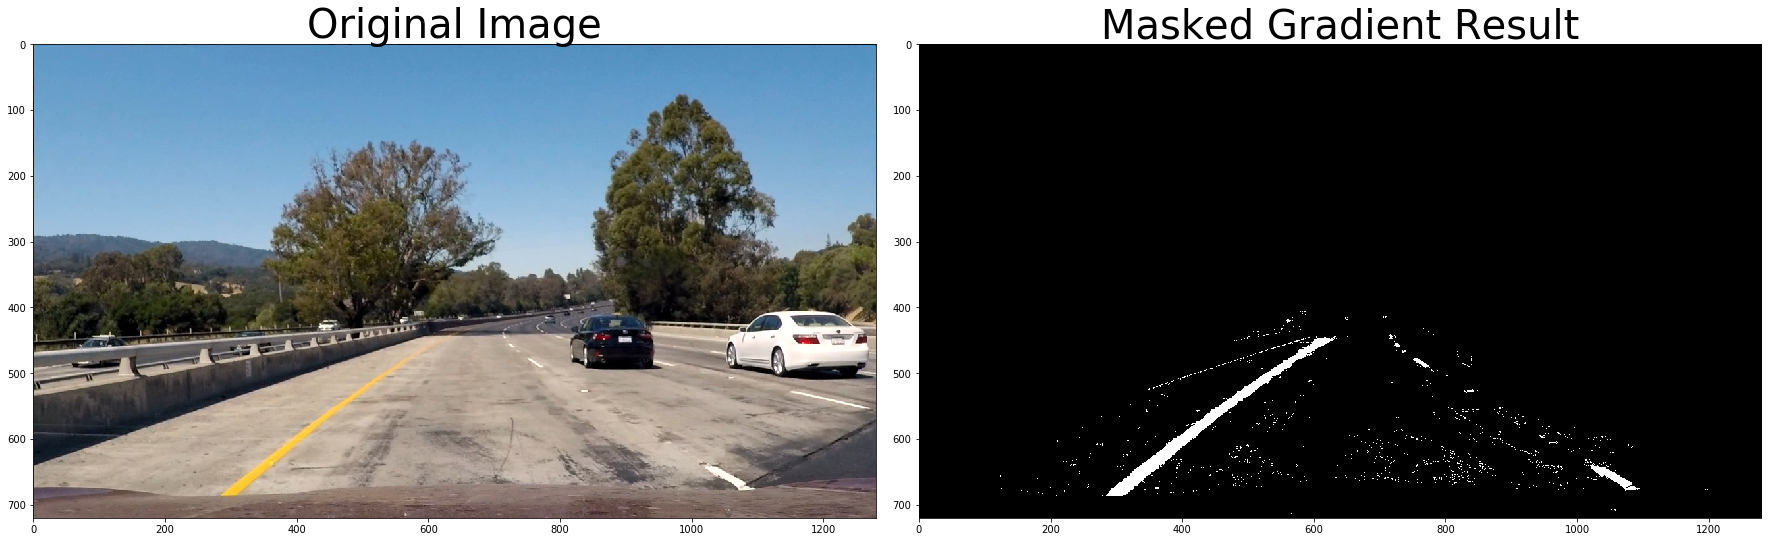

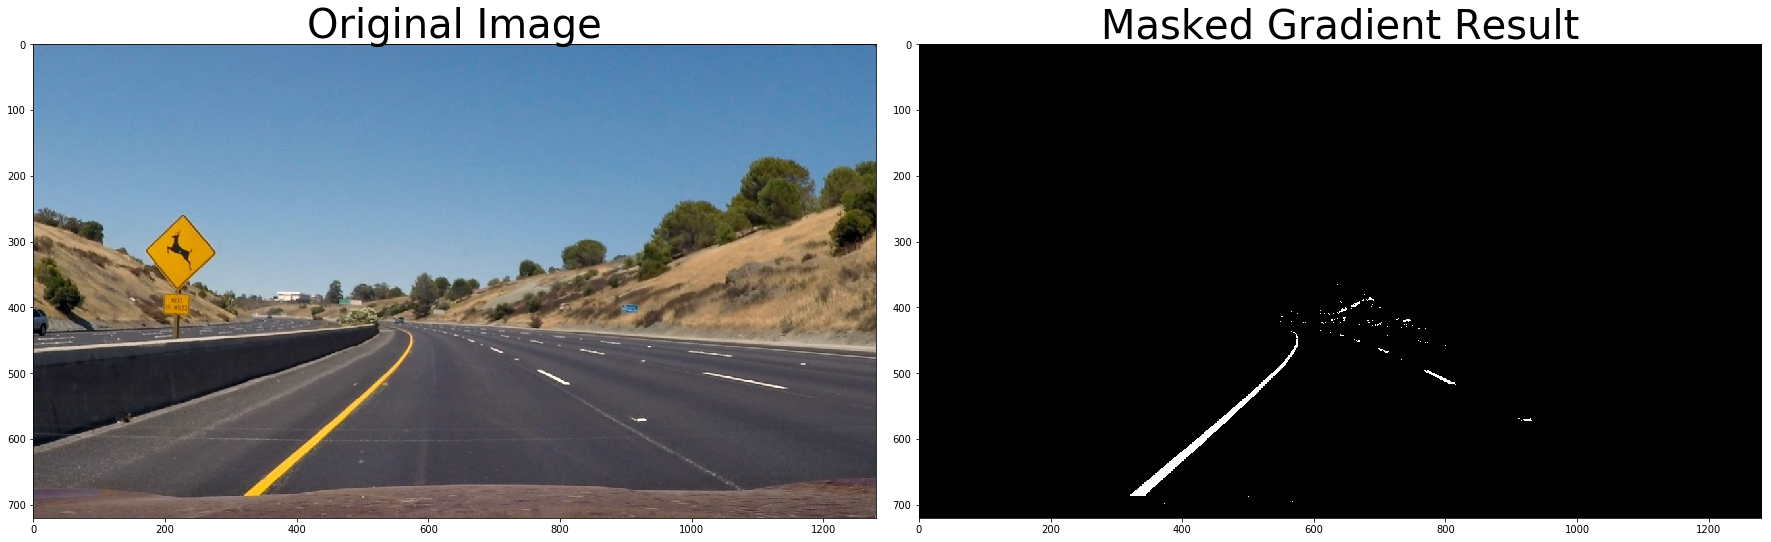

In [41]:
image = mpimg.imread('test_images/test1.jpg')
result = Gradient_Threshold(image)
result = apply_roi(result)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result, cmap='gray')
ax2.set_title('Masked Gradient Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

image = mpimg.imread('test_images/test2.jpg')
result = Gradient_Threshold(image)
result = apply_roi(result)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result, cmap='gray')
ax2.set_title('Masked Gradient Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
def source():
    src = np.float32([
            [220,720],
            [1120,720],
            [570,470],
            [720,470]
        ])
    return src

def destination():
    dst = np.float32([
        [320,720],
        [920,720],
        [320,1],
        [920,1]
    ])
    return dst

def GetPerspectiveTransformMatrix(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

## Bird's Eye View Visualization using perspective transform

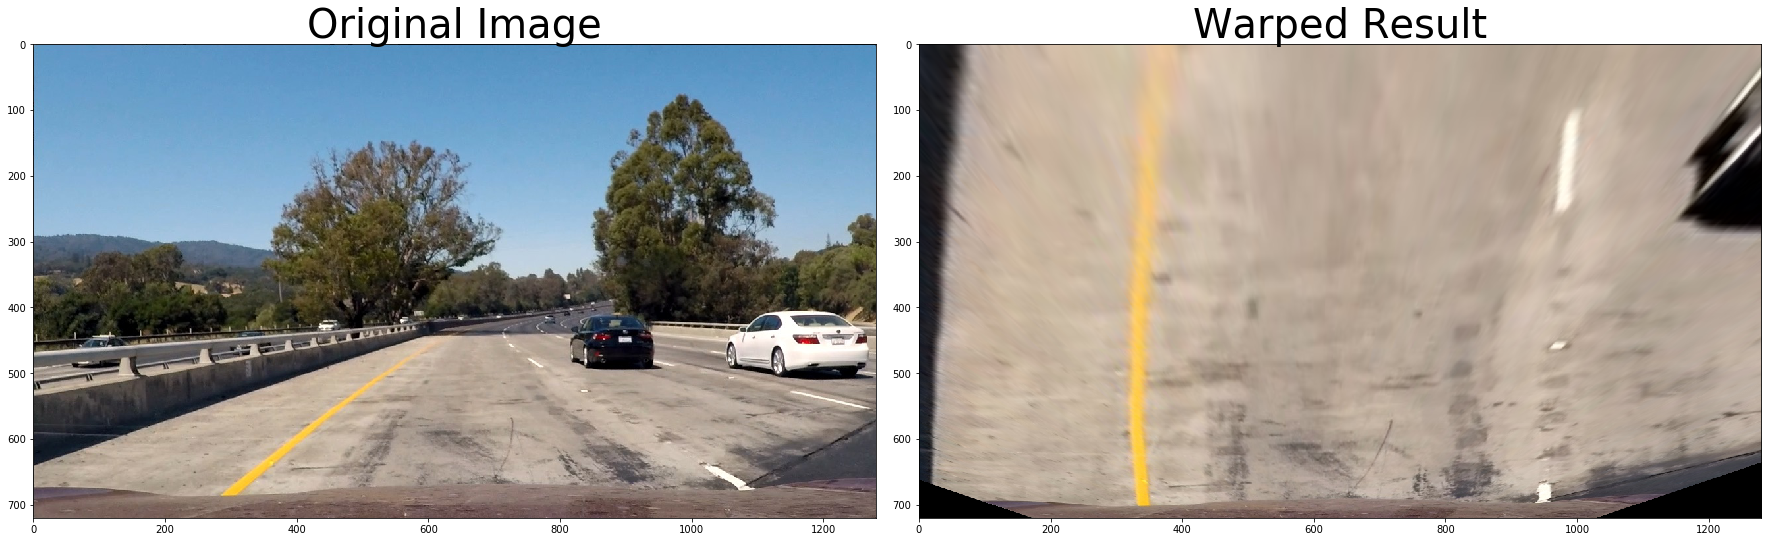

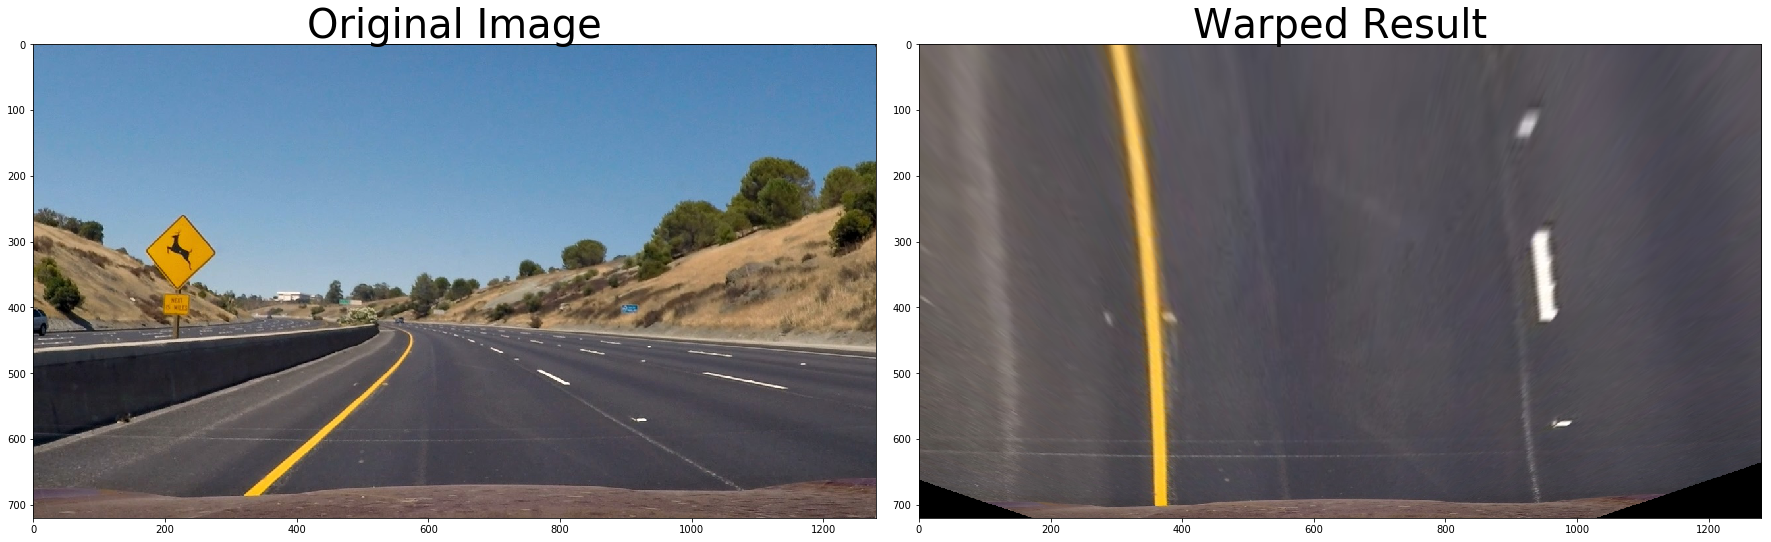

In [40]:
image = mpimg.imread('test_images/test1.jpg')
img_shape = image.shape
img_size = (img_shape[1], img_shape[0])  
unwarped = cv2.warpPerspective(image, M, img_size , flags=cv2.INTER_LINEAR) 

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(unwarped, cmap='gray')
ax2.set_title('Warped Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


image = mpimg.imread('test_images/test2.jpg')
img_shape = image.shape
img_size = (img_shape[1], img_shape[0])  
unwarped = cv2.warpPerspective(image, M, img_size , flags=cv2.INTER_LINEAR) 

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(unwarped, cmap='gray')
ax2.set_title('Warped Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

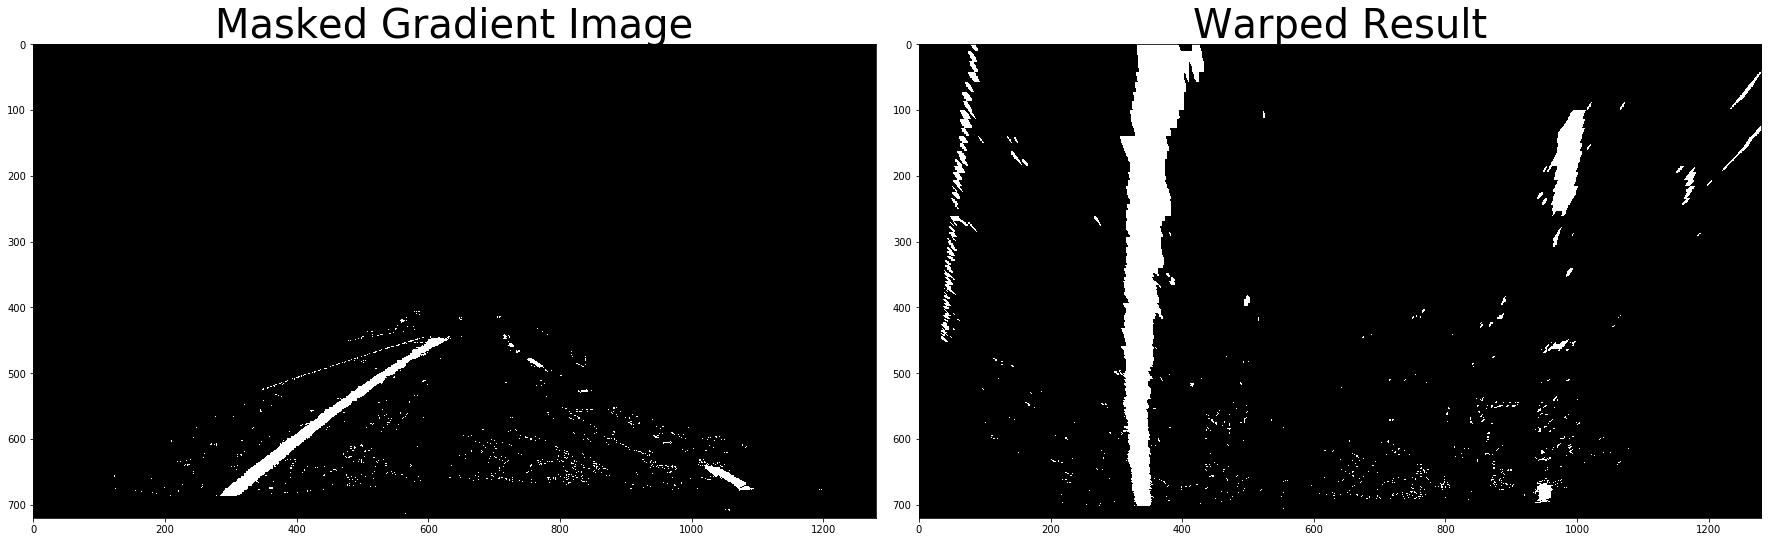

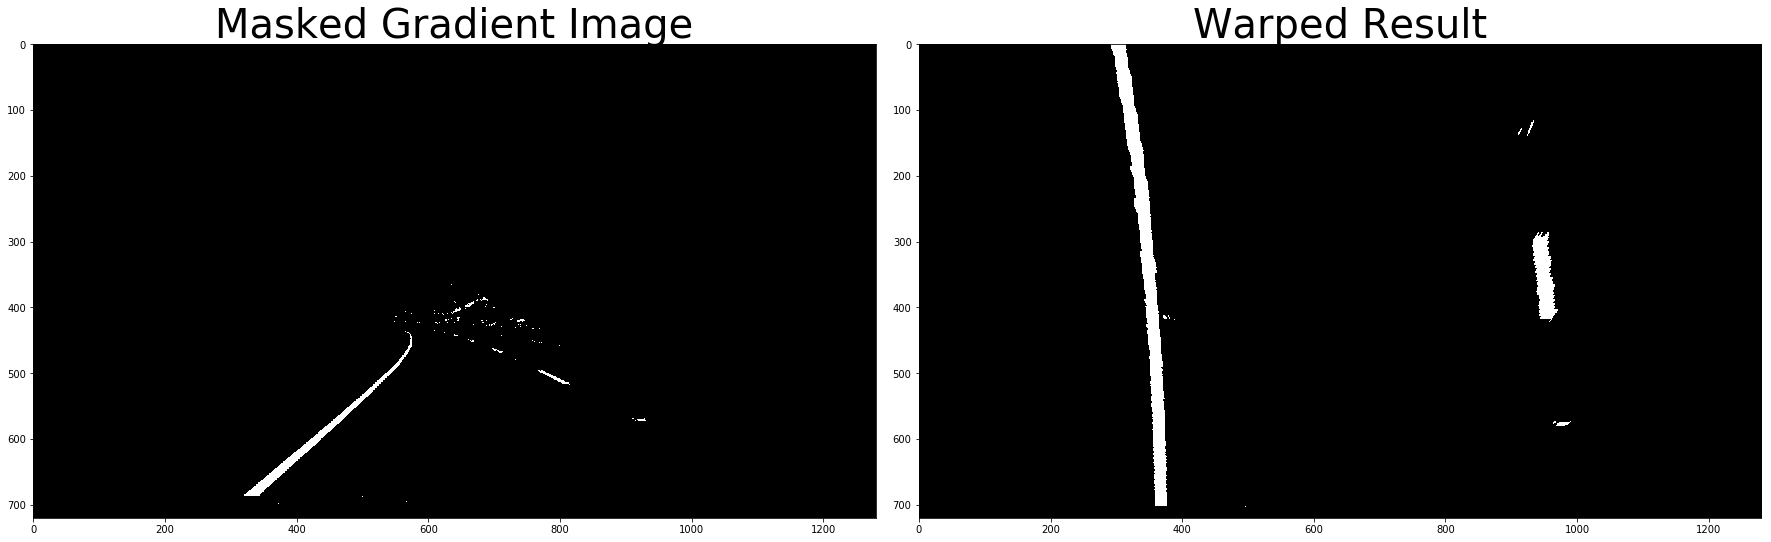

In [43]:
image = mpimg.imread('test_images/test1.jpg')
img_shape = image.shape
img_size = (img_shape[1], img_shape[0])  
binary = Gradient_Threshold(image)
binary_roi = apply_roi(binary)
unwarped = cv2.warpPerspective(binary_roi, M, img_size , flags=cv2.INTER_LINEAR) 
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_roi, cmap='gray')
ax1.set_title('Masked Gradient Image', fontsize=40)
ax2.imshow(unwarped, cmap='gray')
ax2.set_title('Warped Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


image = mpimg.imread('test_images/test2.jpg')
img_shape = image.shape
img_size = (img_shape[1], img_shape[0])  
binary = Gradient_Threshold(image)
binary_roi = apply_roi(binary)
unwarped = cv2.warpPerspective(binary_roi, M, img_size , flags=cv2.INTER_LINEAR) 
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_roi, cmap='gray')
ax1.set_title('Masked Gradient Image', fontsize=40)
ax2.imshow(unwarped, cmap='gray')
ax2.set_title('Warped Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [16]:
def measure_radius_of_curvature(x_values):
    """
    This Function measures and returns radius of curvature for a given set of line vlaues
    """
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, 719, 720)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

In [17]:
# def Predict_Lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, num_rows):
#     """
#     This Function Predicts the left and right lane line x values for a given set 
#     of nonzero x,y and left and right lane indices
#     """
#     leftx = nonzerox[left_lane_inds]
#     lefty = nonzeroy[left_lane_inds]
    
#     # If no pixels were found return None
#     if(lefty.size == 0 or leftx.size == 0):
#         return None, None

#     # Fit the polynomial
#     polyfit_left = np.polyfit(lefty, leftx, 2)

#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds]
    
#     # If no pixels were found return None
#     if(righty.size == 0 or rightx.size == 0):
#         return None, None

#     # Fit the polynomial
#     polyfit_right = np.polyfit(righty, rightx, 2)

#     # If no pixels were found return None
#     y_points = np.linspace(0, num_rows-1, num_rows)
    
#     # Generate the lane lines from the polynomial fit
#     left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
#     right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
#     return left_x_predictions, right_x_predictions

In [85]:
def Initial_LineSearch(binary_warped):
    """
    This function searches for lane lines from scratch.
    It performs a sliding window search and takes in binary warped image
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    #For Visualization
    #plt.plot(histogram)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
     # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    nwindows = 10
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
         # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)      
    
    return left_lane_inds, right_lane_inds

In [86]:
def Center_Offset(image, l_fit_x, r_fit_x):
    """
    This function calculates the offset of the center of the car.
    """
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    camera_position = image.shape[1] / 2
    center_of_lane = (r_fit_x[719] + l_fit_x[719]) /2
    offset = (camera_position - center_of_lane) * xm_per_pix
    return offset

def DrawText(image, left_curverad, right_curverad, center_offset):
    """
    This function draws the text values of radious of curvature and center offset
    """
    text1 = 'Curve radius: {0} m. '.format((int(left_curverad) + int(right_curverad)) / 2 )    
    direction = ''
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'
    text2 = '{:04.3f}'.format(abs(center_offset)) + 'm ' + direction + ' of center'
    cv2.putText(image, text1,(40,70),cv2.FONT_HERSHEY_DUPLEX,2,(255,255,255), 2, cv2.LINE_AA)
    cv2.putText(image, text2, (40, 130), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
    return image

In [94]:
class Lane():
    """
    The Lane class keeps the characterisitics of the left and right lines for lane detection
    """
    def __init__(self):       
        # was the lines detected correctly in the last iteration?
        self.detected = False
        # x values of the last n indices of the left line
        self.recentleft_xfitted = []
        # x values of the last n indices of the right line
        self.recentright_xfitted = []       
        # avg difference b/w the left and right lines
        self.avg_diff_lines = 0
        self.left_fit = None
        self.right_fit = None
        
    def cal_recentaverage_line(self, line, new_line_inds):
        """
        This function calculates and returns the recent average of the line indices over the last n frames
        n frames being 10 here
        """
        # Number of frames to average over
        num_frames = 10

        if line == 'left':
            lineX_Vals = self.recentleft_xfitted
        else:
            lineX_Vals = self.recentright_xfitted

        if new_line_inds is None:
            # No line was detected        
            if len(lineX_Vals) == 0:
                # If there are no previous lines, return None
                return None
            else:
                # Else return the last line
                return previous_lines[-1]
        else:
            if len(lineX_Vals) < num_frames:
                # we need at least num_frames frames to average over
                lineX_Vals.append(new_line_inds)
                new_line_inds = np.zeros_like(new_line_inds)
                new_line_inds = np.mean(lineX_Vals, axis=0)
                return new_line_inds
            else:
                # average over the last num_frames frames
                lineX_Vals[0:num_frames-1] = lineX_Vals[1:]
                lineX_Vals[num_frames-1] = new_line_inds
                new_line_inds = np.zeros_like(new_line_inds)
                new_line_inds = np.mean(lineX_Vals, axis=0)
                return new_line_inds
            
    def verify_detectedlines(self, leftx_inds, rightx_inds):
        """
        This function verifies whether the detected lines are good or bad. 
        And returns True if they can be kept else returns False to reject
        """
        detectedlines_keep = True

        if (leftx_inds is None or rightx_inds is None):
            detectedlines_keep = False
        else:
            diff = np.mean(rightx_inds - leftx_inds)

            if self.avg_diff_lines == 0:
                self.avg_diff_lines = diff

            if (abs(diff - self.avg_diff_lines) > 100):
                detectedlines_keep = False
            else:
                detectedlines_keep = True
                
        return detectedlines_keep

    def calc_mean_diff_lines(self, left_x_predictions, right_x_predictions):
        """
        This function calculates and stores the mean/avg difference of the lines 
        by taking weightage of the previous and newly lines
        """
        diff = np.mean(right_x_predictions - left_x_predictions)
        if self.avg_diff_lines == 0:
            self.avg_diff_lines = diff
        else:
            self.avg_diff_lines = 0.85*self.avg_diff_lines + 0.15*diff
            
    def predict_lines(self, binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, num_rows):
        """
        This Function Predicts the left and right lane line x values for a given set 
        of nonzero x,y and left and right lane indices
        """
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]

        # If no pixels were found return None
        if(lefty.size == 0 or leftx.size == 0):
            return None, None

        # Fit the polynomial
        self.left_fit = np.polyfit(lefty, leftx, 2)

        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # If no pixels were found return None
        if(righty.size == 0 or rightx.size == 0):
            return None, None

        # Fit the polynomial
        self.right_fit = np.polyfit(righty, rightx, 2)

        # If no pixels were found return None
        y_points = np.linspace(0, num_rows-1, num_rows)

        # Generate the lane lines from the polynomial fit
        left_x_predictions = self.left_fit[0]*y_points**2 + self.left_fit[1]*y_points + self.left_fit[2]
        right_x_predictions = self.right_fit[0]*y_points**2 + self.right_fit[1]*y_points + self.right_fit[2]

#         #For Visualization
#         # Generate x and y values for plotting
#         # Fit a second order polynomial to each
#         out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#         ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#         out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#         out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#         plt.imshow(out_img)
#         plt.plot(left_x_predictions, ploty, color='yellow')
#         plt.plot(right_x_predictions, ploty, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)
        return left_x_predictions, right_x_predictions

In [92]:
def Look_AheadSearch(binary_warped, left_fit, right_fit):
    """
    This function searches the left and right lane indices ahead based on the previous left and right fit values
    """
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
            
    return left_lane_inds, right_lane_inds

In [89]:
def Pipeline(img, mtx, dist, M, Minv): 
    """
    This is the main pipeline function where all the functions are called in sequence to process the image
    """
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])       
    
    # 1) Undistort using mtx and dist
    undistort = cv2.undistort(img, mtx, dist, None, mtx)        
    
    # 2) Get the binary warped image by applying gradient threshold
    binary_combined = Gradient_Threshold(undistort)
    
    # 3) Get the ROI Binary Image
    roi_binary = apply_roi(binary_combined)
       
    # 4) Warp the undistorted image
    warped = cv2.warpPerspective(roi_binary, M, img_size , flags=cv2.INTER_LINEAR) 
    
    nonzeros = warped.nonzero()
    nonzerosy = nonzeros[0]
    nonzerosx = nonzeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)    
    
    if (lane.left_fit is None) or (lane.right_fit is None):
        left_coordinates, right_coordinates = Initial_LineSearch(warped)
        left_x_predictions, right_x_predictions = lane.predict_lines(warped, nonzerosx, nonzerosy, left_coordinates, right_coordinates, num_rows)
        lane.detected = True
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        left_coordinates, right_coordinates = Look_AheadSearch(warped, lane.left_fit, lane.right_fit)
        left_x_predictions, right_x_predictions = lane.predict_lines(warped, nonzerosx, nonzerosy, left_coordinates, right_coordinates, num_rows)
        lane.detected = False
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not lane.detected:
            left_x_predictions, right_x_predictions = Initial_LineSearch(warped)
    
    detectedlines_good = lane.verify_detectedlines(left_x_predictions, right_x_predictions)
    
    if not detectedlines_good:
        lane.left_fit = None
        lane.right_fit = None
        if len(lane.recentleft_xfitted) == 0 and len(lane.recentright_xfitted) == 0:
            return img            
        else:
            left_x_predictions = lane.recentleft_xfitted[-1]
            right_x_predictions = lane.recentright_xfitted[-1]
    else:
        left_x_predictions = lane.cal_recentaverage_line('left', left_x_predictions)
        right_x_predictions = lane.cal_recentaverage_line('right', right_x_predictions)
        lane.calc_mean_diff_lines(left_x_predictions, right_x_predictions)
    
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points])))) 
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    out_img = np.dstack((warped, warped, warped))*255
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    
    # compute the offset from the center
    center_offset = Center_Offset(img, left_x_predictions, right_x_predictions)
    result = DrawText(result, left_curve_rad, right_curve_rad, center_offset)
    
    return result

In [12]:
mtx, dist = Calibrate_Camera()

In [13]:
M, Minv = GetPerspectiveTransformMatrix(source(), destination())

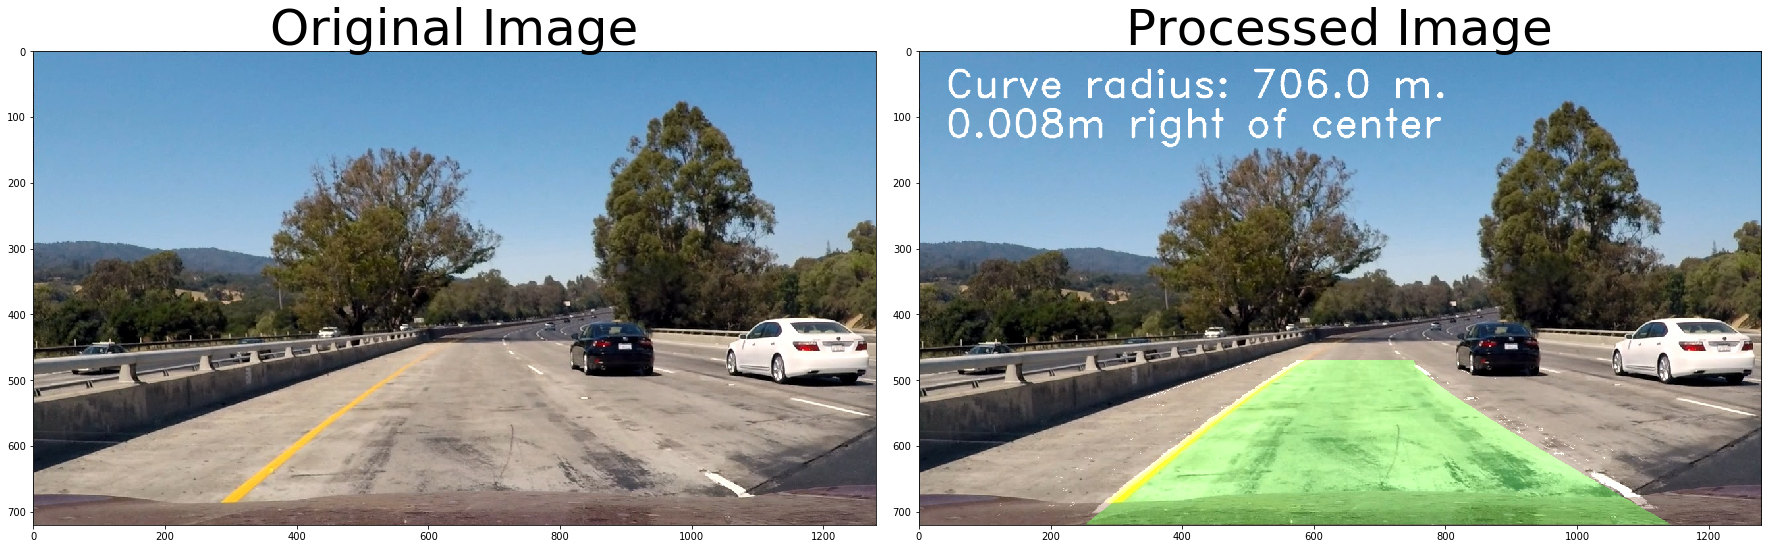

In [95]:
img = mpimg.imread('test_images/test1.jpg')

# Reinitialize some global variables.
lane = Lane()

# Apply pipeline
processed = Pipeline(img, mtx, dist, M, Minv)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [32]:
def process_image(image):
    result = Pipeline(image, mtx, dist, M, Minv)
    return result

In [ ]:
directory = "test_videos_output"
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Reinitialize some global variables.
lane = Lane()
    
write_output = 'test_videos_output/project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(write_output, audio=False)

In [33]:
directory = "test_videos_output"
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Reinitialize some global variables.
lane = Lane()
    
write_output = 'test_videos_output/challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video_out.mp4
[MoviePy] Writing video test_videos_output/challenge_video_out.mp4


100%|████████████████████████████████████████| 485/485 [02:45<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video_out.mp4 

Wall time: 2min 47s
